# AST Fine Tuning

An aproach to AST. Although this model was not originally designed for Audio Classification, we can adapt it for the task.

In [1]:
import torch
import torch.nn as nn
import torchaudio
import torchaudio.transforms as T
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset, DatasetDict, Audio, ClassLabel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from transformers import AutoFeatureExtractor, ASTForAudioClassification, TrainingArguments, Trainer

SEED = 2706

c:\Users\faler\anaconda3\envs\tfm_audio\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ==========================
# Initial config
# ==========================

MODEL_ID = "MIT/ast-finetuned-audioset-10-10-0.4593"
CSV_PATH = "./audio_data/complete_metadata.csv"   
AUDIO_COL = "Path"      
LABEL_COL = "Emotion"

# Labels
labels = ["Angry", "Happy", "Fearful", "Sad", "Disgust", "Neutral"]
num_labels = len(labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We will not perform here data augmentation, so we just load the paths from the recordings and divide the dataset into train and test. Like with the other models, we leave out 'Calm' and 'Surprised' emotions.

In [3]:
# Load paths
audios = pd.read_csv(CSV_PATH)
audios = audios[~((audios[LABEL_COL] == 'Calm') | (audios[LABEL_COL] == 'Surprised'))]
audios = audios.rename(mapper={'Path': 'file', 'Emotion':'labels'}, axis=1)
audios = audios.drop(columns=['Dataset', 'Emotional_level'], errors='ignore')

dataset = Dataset.from_pandas(audios)

# Split
dataset = dataset.train_test_split(test_size=0.2, seed=SEED)
dataset = DatasetDict({
    "train": dataset["train"].train_test_split(test_size=0.2, seed=SEED)["train"],
    "test": dataset["test"]
})

## Preprocessing

Now we preprocess the data. It is fairly simple. We use the automatic feature extractor from Hugging Face after applying an audio transformation (using sampling rate of 16kHz, which is a requirement for this model).

In [4]:
# Turn to audio files all paths from the dataset
dataset = dataset.cast_column("file", Audio(sampling_rate=16000))

# Feature extractor
extractor = AutoFeatureExtractor.from_pretrained(MODEL_ID)

In [5]:
def preprocess(batch: dict) -> dict:
    """
    Preprocess a batch element by extracting input features from raw audio.

    Steps:
        - Load raw audio from the batch.
        - Use the feature extractor to process the waveform.
        - Add extracted input values back into the batch.

    Args:
        batch: Dictionary containing:
            - "file": A dictionary with keys:
                - "array": The raw audio waveform (NumPy array).
                - "sampling_rate": Sampling rate of the audio.

    Returns:
        dict: Updated batch with an additional key:
            - "input_values": Extracted input features for the model.
    """
    audio = batch["file"]

    # Extract input features using the global extractor
    inputs = extractor(audio["array"], sampling_rate=audio["sampling_rate"])

    # Store the first feature array in the batch
    batch["input_values"] = inputs["input_values"][0]

    return batch

dataset = dataset.map(preprocess, remove_columns=["file"])

Map: 100%|██████████| 1906/1906 [00:29<00:00, 64.49 examples/s]


Now we prepare the labels for the training. This model requires integer labels, so we apply the ClassLabel method from datasets.

In [6]:
all_labels = sorted(dataset["train"].unique("labels"))
dataset = dataset.cast_column("labels", ClassLabel(names=all_labels))

id2label = {i: l for i, l in enumerate(dataset["train"].features["labels"].names)}
label2id = {l: i for i, l in enumerate(dataset["train"].features["labels"].names)}

Casting the dataset: 100%|██████████| 1906/1906 [00:00<00:00, 25531.00 examples/s]


## Load the model

We prepare the model for fine-tuning.

In [7]:
model = ASTForAudioClassification.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593",
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

# Helps save VRAM
model.gradient_checkpointing_enable()
model.config.use_cache = False

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Let's get ready for the training. We have to define a data collator to help the model process the audios. Also, we need to define the metrics that will be looked up to determine if we are in the right path while training. 

For the data collator, it is not necessary to define it as a class.

In [8]:
class DataCollatorAST:
    """
    Data collator for preparing batches of audio spectrogram features.

    This class is designed to:
        - Convert input feature arrays into float tensors.
        - Pad input sequences to the maximum length in the batch.
        - Convert labels into a long tensor.

    Returns a dictionary ready for model consumption.
    """

    def __call__(self, features: list[dict]) -> dict[str, torch.Tensor]:
        """
        Collate a batch of features into padded tensors.

        Args:
            features: List of dictionaries, each containing:
                - "input_values": Input feature array (1D or 2D sequence).
                - "labels": Integer label.

        Returns:
            dict: A dictionary with:
                - "input_values": Float tensor of shape [batch_size, max_seq_len, ...],
                  padded with zeros.
                - "labels": Long tensor of shape [batch_size].
        """
        # Convert input values to float tensors
        input_values = [
            torch.tensor(f["input_values"], dtype=torch.float32) for f in features
        ]

        # Convert labels to a long tensor
        labels = torch.tensor([f["labels"] for f in features], dtype=torch.long)

        # Pad input sequences to the maximum length in the batch
        input_values = torch.nn.utils.rnn.pad_sequence(
            input_values, batch_first=True, padding_value=0.0
        )

        return {"input_values": input_values, "labels": labels}


data_collator = DataCollatorAST()

Finally, we give the trainer all parameters necessary.

In [9]:
# ------------------------------
# TrainingArguments
# ------------------------------
training_args = TrainingArguments(
    output_dir="./ast-emotion",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=True,                       # mixed precision
    remove_unused_columns=False,     # avoid forward errors
    dataloader_pin_memory=True,
    report_to="none"
)

# ------------------------------
# Metrics
# ------------------------------
def compute_metrics(eval_pred: tuple[np.ndarray, np.ndarray]) -> dict[str, float]:
    """
    Compute evaluation metrics for classification tasks.

    Metrics:
        - Accuracy
        - Weighted F1 score

    Args:
        eval_pred: Tuple containing:
            - logits: NumPy array of shape [num_samples, num_classes].
            - labels: NumPy array of shape [num_samples].

    Returns:
        dict: A dictionary with:
            - "accuracy": Accuracy score.
            - "f1": Weighted F1 score.
    """
    logits, labels = eval_pred

    # Get predicted class indices from logits
    preds = np.argmax(logits, axis=-1)

    # Compute accuracy and F1 score
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
    }

# ------------------------------
# Trainer
# ------------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=extractor,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

C:\Users\faler\AppData\Local\Temp\ipykernel_17760\585708512.py:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [10]:
trainer.train()

c:\Users\faler\anaconda3\envs\tfm_audio\lib\site-packages\transformers\integrations\sdpa_attention.py:89: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.252900,1.281304,0.523085,0.472612
2,0.976400,1.158995,0.566107,0.554646
3,0.563800,1.013968,0.654250,0.645437
4,0.251600,1.169186,0.667891,0.663116
5,0.088800,1.381479,0.666317,0.659371
6,0.046500,1.590088,0.681532,0.678337
7,0.021600,1.760479,0.672088,0.672916
8,0.001500,1.777339,0.694124,0.692521
9,0.000200,1.763265,0.693599,0.693948
10,0.000100,1.767331,0.698846,0.698514


TrainOutput(global_step=1910, training_loss=0.33943406536758275, metrics={'train_runtime': 9103.9318, 'train_samples_per_second': 6.697, 'train_steps_per_second': 0.21, 'total_flos': 4.1328672387209626e+18, 'train_loss': 0.33943406536758275, 'epoch': 10.0})

## Results

Following previous studies as in with ML and DL, we plot the confusion matrix and the classification report.

In [11]:
results = trainer.evaluate(dataset["test"])
print(results)

{'eval_loss': 1.7673306465148926, 'eval_accuracy': 0.6988457502623295, 'eval_f1': 0.6985141865049912, 'eval_runtime': 130.2901, 'eval_samples_per_second': 14.629, 'eval_steps_per_second': 0.461, 'epoch': 10.0}


              precision    recall  f1-score   support

       Angry       0.83      0.80      0.81       334
     Disgust       0.67      0.66      0.66       319
     Fearful       0.64      0.65      0.64       325
       Happy       0.70      0.72      0.71       316
     Neutral       0.72      0.78      0.75       258
         Sad       0.65      0.61      0.63       354

    accuracy                           0.70      1906
   macro avg       0.70      0.70      0.70      1906
weighted avg       0.70      0.70      0.70      1906



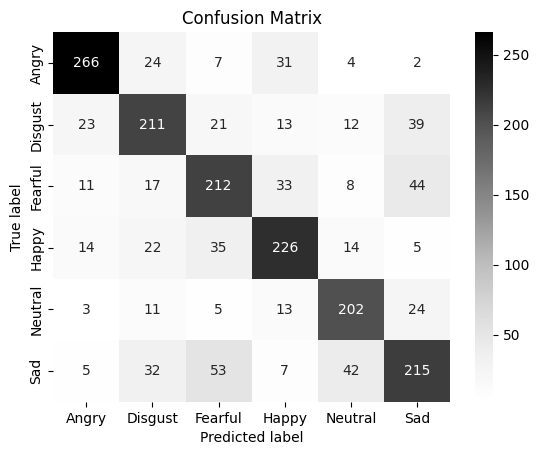

In [12]:
# ==========================
# Confusion matrix
# ==========================
preds = trainer.predict(dataset["test"])
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)

# Report
print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(len(id2label))]))

# Plot
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Greys",
    xticklabels=[id2label[i] for i in range(len(id2label))],
    yticklabels=[id2label[i] for i in range(len(id2label))]
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()


We save the model in case we want to reconstruct it.

In [13]:
model.save_pretrained("models/ast-classifier")

In short, the model shows average accuracy of 70%, which improves the results for ML and DL models. It is better than them and although it makes some mistakes, generally it classifies well.